# Animation using direct access to simulation data

## Pre-requisites

For this to work in Jupyter Lab you need to have sk the `@jupyter-widgets/jupyterlab-manager` and `jupyter-matplotlib` extensions installed. On some systems this requires doing:

```
> jupyter labextension install @jupyter-widgets/jupyterlab-manager
> jupyter labextension install jupyter-matplotlib
```

## Animation of the Two-Stream instability

In this more advanced example, we show how to create a movie of the particles phasespace using direct access to the simulation data. The initialization of the simulation is done the normal way:

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d as zpic

import numpy as np

nx = 120
box = 4 * np.pi
dt = 0.1
tmax = 50.0

ppc = 500
ufl = [0.2,    0.0,  0.0]
uth = [0.001,0.001,0.001]

right = zpic.Species( "right", -1.0, ppc, ufl = ufl, uth = uth )

ufl[0] = -ufl[0]
left  = zpic.Species( "left", -1.0, ppc, ufl = ufl, uth = uth )

# Initialize the simulation without diagnostics
sim = zpic.Simulation( nx, box, dt, species = [right,left] )


Instead of calling the `run` method as usual, we chose to call the `iter` method instead, that advances the simulation 1 time step. This is done inside an `animate` function that is responsible for updating the movie frames.

To lower the overall frame count and speed up things, we don't create a frame for every iteration, and automatically skip a few iterations based on the movie parameters.

Note that for this particular example, the time is mostly spent generating the animation, the simulation time is almost negligible.

HTML(value='<video width="1066" height="600" controls autoplay>\n  <source type="video/mp4" src="data:video/mp…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
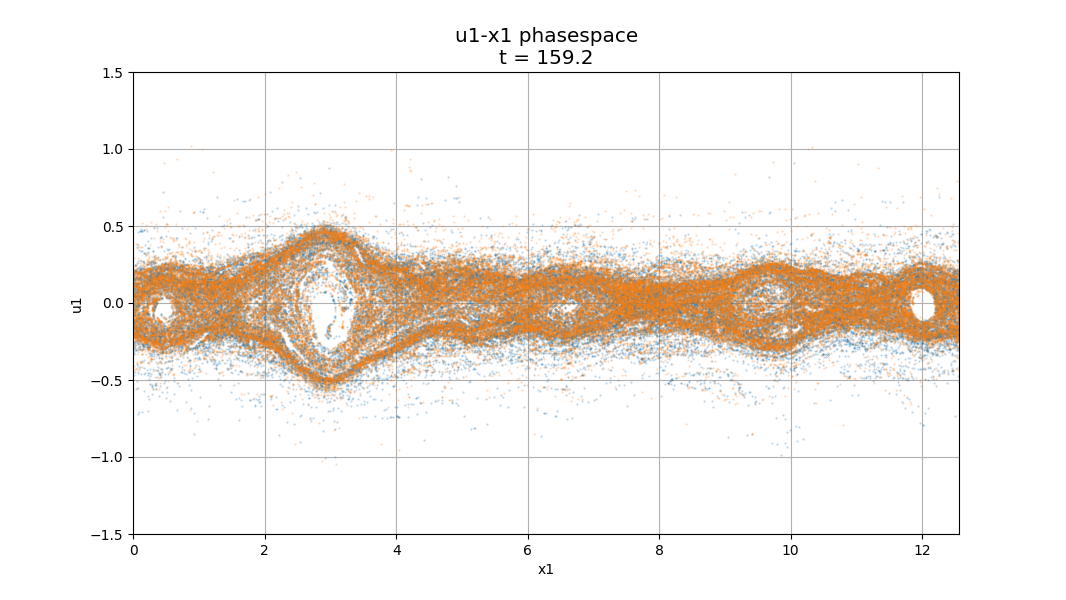

In [2]:
%matplotlib widget

import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import display
import ipywidgets

# Movie parameters
nframes = 200
tmax = 150.0
fps = 16

# Create progress bar
bar   = ipywidgets.FloatProgress( min = 0, max = 200 )
label = ipywidgets.HTML()
prog  = ipywidgets.VBox(children=[label, bar])
display(prog)

# Create plot
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx

fig, ax = plt.subplots()

plt.rc('font', size=12)   
fig.set_size_inches( (10.66,6.0) )

(p1,) = ax.plot([], [],  '.', ms=1,alpha=0.3, label = "Left")
(p2,) = ax.plot([], [], '.', ms=1,alpha=0.3, label = "Right")
ax.set_xlabel("x1")
ax.set_ylabel("u1")
ax.set_title("u1-x1 phasespace\nt = {:.1f}".format(sim.t))
ax.grid(True)

ax.set_xlim( (0,box ))
ax.set_ylim( (-1.5, 1.5) )

# Function to create each movie frame
skip  = np.int32(np.ceil((tmax / dt ) / (nframes-1) ))

def animate(i):
    label.value = "Generating frame {:d}/200 ...".format(i+1)
    bar.value = i
    
    if ( i > 0 ):
        for j in range(skip):
            sim.iter()
    
    p1.set_xdata(x(left))
    p1.set_ydata(left.particles['ux'])

    p2.set_xdata(x(right))
    p2.set_ydata(right.particles['ux'])

    ax.set_title("u1-x1 phasespace\nt = {:.1f}".format(sim.t))

    return (p1,p2)

# Create the movie
anim = animation.FuncAnimation( fig, animate, frames = nframes, repeat = False, blit = True, interval = 1000.0/fps )
movie = ipywidgets.HTML(anim.to_html5_video())

# Show the completed movie
label.value = "Done!"
bar.bar_style = "success"
display(movie)